

# Regression-Master Template

In this jupyter note you will work through a case study regression predictive modeling problem in Python
including each step of the applied machine learning process. 


## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Feature Selection](#3.2)
    * [4.3.Data Transformation](#3.3) 
        * [4.3.1 Rescaling ](#3.3.1)
        * [4.3.2 Standardization](#3.3.2)
        * [4.3.3 Normalization](#3.3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Common Classification Models](#4.3.1)
        * [5.3.2 Ensemble Models](#4.3.2)
        * [5.3.3 Deep Learning Models](#4.3.3)  
    * [5.4. Time Series based Models-ARIMA and LSTM](#4.4)
        * [5.4.1 ARIMA Model](#4.4.1)
        * [5.4.2 LSTM Model](#4.4.2) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Introduction

Our goal in this jupyter notebook is to under the following
- How to work through a predictive modeling problem end-to-end. This notebook is applicable both for regression and classification problems.
- How to use data transforms to improve model performance.
- How to use algorithm tuning to improve model performance.
- How to use ensemble methods and tuning of ensemble methods to improve model performance.
- How to use deep Learning methods.
- Following Models are implemented

    * Linear Regression
    * Lasso
    * Elastic Net 
    * KNN
    * Decision Tree (CART)
    * Support Vector Machine 
    * Ada Boost
    * Gradient Boosting Method
    * Random Forest
    * Extra Trees
    * Neural Network - Shallow - Using sklearn
    * Deep Neural Network - Using Keras
    * LSTM - Using Keras
    

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [100]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Loading the Data

In [12]:
# Get the data by webscapping using pandas datareader
return_period = 21


stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([Y.diff(i) for i in [21, 63, 126,252]], axis=1).dropna()
X4.columns = ['1M', '3M', '6M', '1Y']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna()
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [13]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
type(dataset)

pandas.core.frame.DataFrame

#### Converting the data to supervised regression format
All the predictor variables are changed to lagged variable, as the t-1 value of the lagged variable will be used for prediction. 

In [15]:
def series_to_supervised(data, lag=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)    
    cols, names = list(), list()
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = pd.DataFrame(data.iloc[:,0]).join(agg)
    agg.dropna(inplace=True)
    return agg

In [16]:
dataset= series_to_supervised(dataset,1)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [17]:
# shape
dataset.shape

(2005, 13)

In [18]:
# peek at data
pd.set_option('display.width', 100)
dataset.head(2)

MSFT_pred  MSFT_pred(t-1)  GOOGL(t-1)  IBM(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  \
2011-01-04  -0.015788       -0.001430    0.055329  0.015719     -0.014243     -0.014930   
2011-01-05  -0.008248       -0.015788    0.049571  0.015426     -0.008988     -0.006013   

            SP500(t-1)  DJIA(t-1)  VIXCLS(t-1)   1M(t-1)   3M(t-1)   6M(t-1)   1Y(t-1)  
2011-01-04    0.037784   0.025045    -0.022460 -0.041166 -0.137312 -0.078562  0.076488  
2011-01-05    0.037769   0.028544    -0.036162 -0.054624 -0.120203 -0.058879  0.090435

In [19]:
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

MSFT_pred         float64
MSFT_pred(t-1)    float64
GOOGL(t-1)        float64
IBM(t-1)          float64
DEXJPUS(t-1)      float64
DEXUSUK(t-1)      float64
SP500(t-1)        float64
DJIA(t-1)         float64
VIXCLS(t-1)       float64
1M(t-1)           float64
3M(t-1)           float64
6M(t-1)           float64
1Y(t-1)           float64
dtype: object

In [20]:
# describe data
pd.set_option('precision', 3)
dataset.describe()

MSFT_pred  MSFT_pred(t-1)  GOOGL(t-1)  IBM(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  SP500(t-1)  \
count   2005.000        2005.000    2005.000  2005.000      2005.000     2.005e+03    2005.000   
mean       0.017           0.017       0.013     0.001         0.002    -1.994e-03       0.008   
std        0.054           0.054       0.063     0.054         0.026     2.301e-02       0.034   
min       -0.152          -0.152      -0.216    -0.287        -0.083    -1.227e-01      -0.183   
25%       -0.016          -0.016      -0.029    -0.031        -0.013    -1.539e-02      -0.009   
50%        0.021           0.021       0.013     0.003         0.001    -7.140e-04       0.012   
75%        0.050           0.050       0.051     0.037         0.016     1.366e-02       0.029   
max        0.217           0.217       0.271     0.219         0.102     6.772e-02       0.110   

       DJIA(t-1)  VIXCLS(t-1)    1M(t-1)    3M(t-1)   6M(t-1)   1Y(t-1)  
count   2005.000    2.005e+03  2.005e+03  2.005e+03  2005.000  2005.000  
mean       0.008   -3.098e-05  1.862e-04 -3.415e-04     0.001     0.004  
std        0.034    2.381e-01  7.958e-02  8.154e-02     0.075     0.079  
min       -0.162   -8.266e-01 -2.585e-01 -2.999e-01    -0.319    -0.288  
25%       -0.010   -1.404e-01 -5.188e-02 -4.694e-02    -0.047    -0.050  
50%        0.011   -1.803e-02  8.440e-05  1.575e-03    -0.002     0.003  
75%        0.030    1.155e-01  4.983e-02  4.946e-02     0.044     0.053  
max        0.103    1.398e+00  2.554e-01  3.310e-01     0.275     0.230

<a id='2.2'></a>
## 3.2. Data Visualization

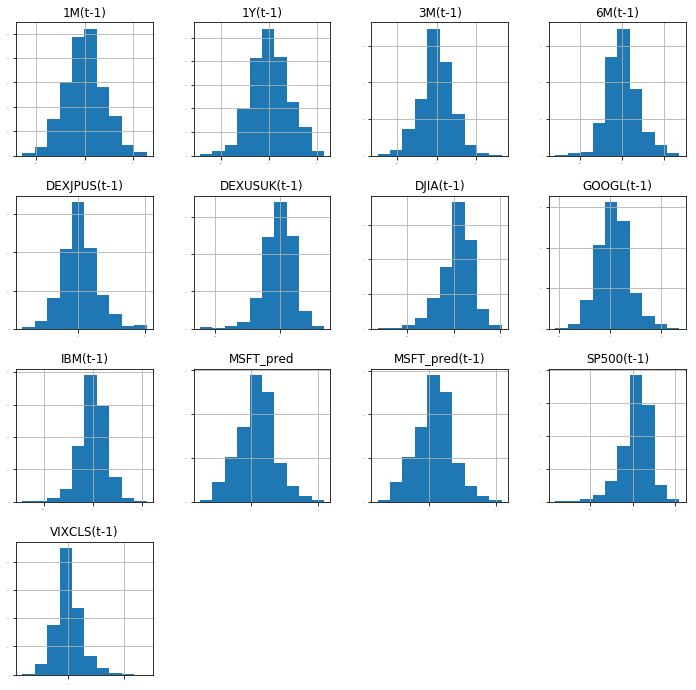

In [21]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

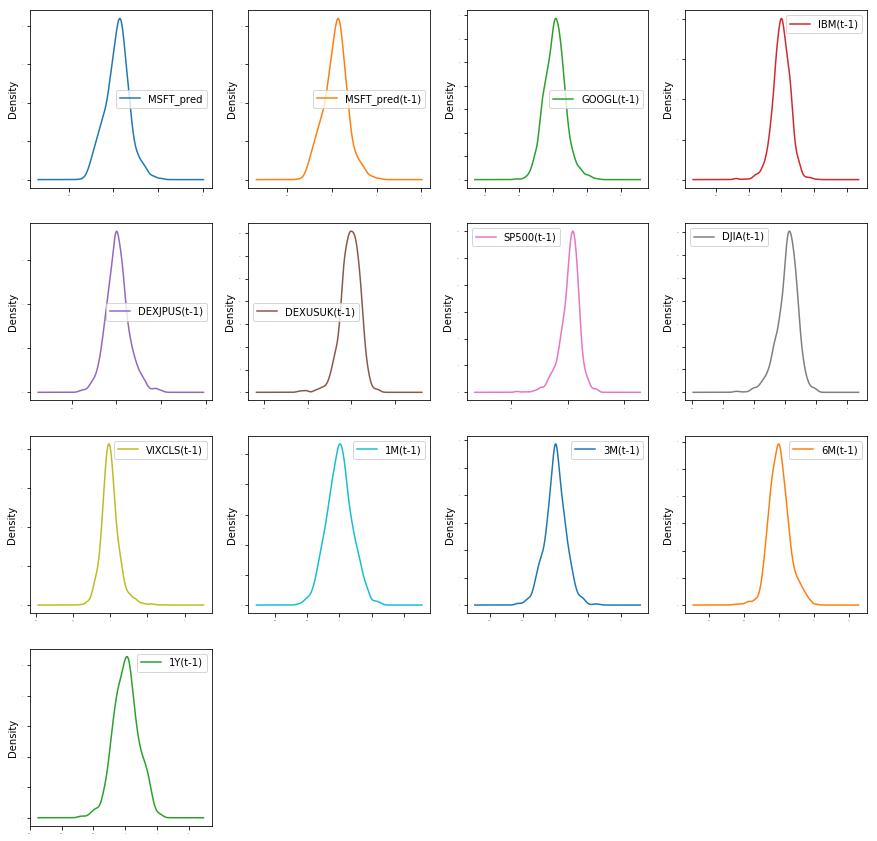

In [22]:
# density
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

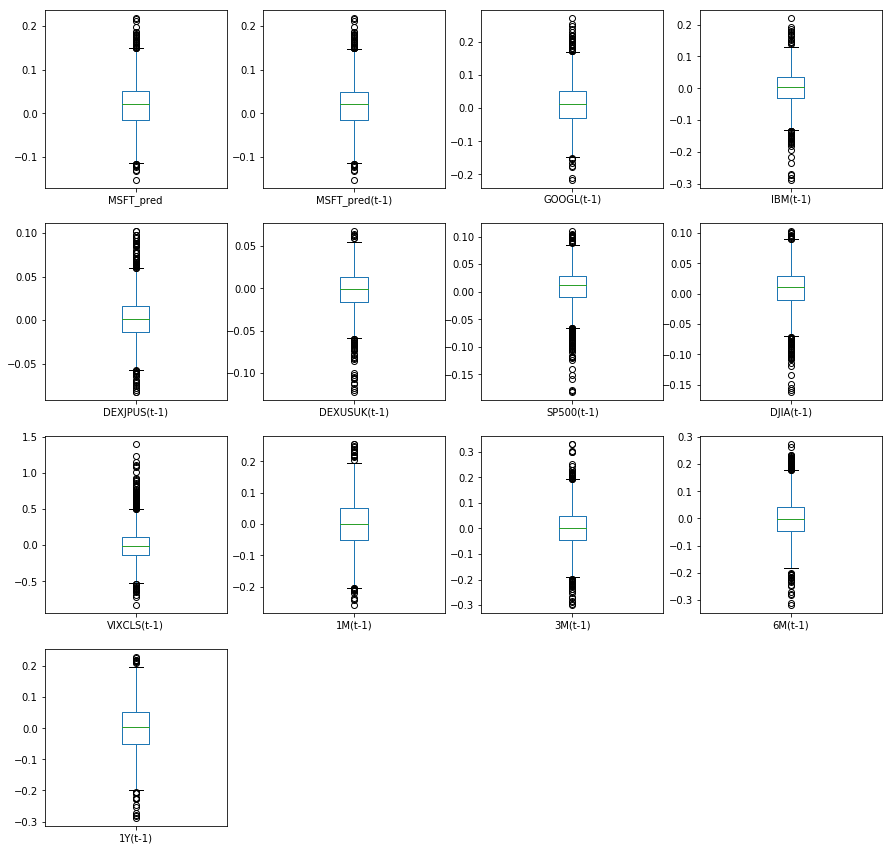

In [23]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

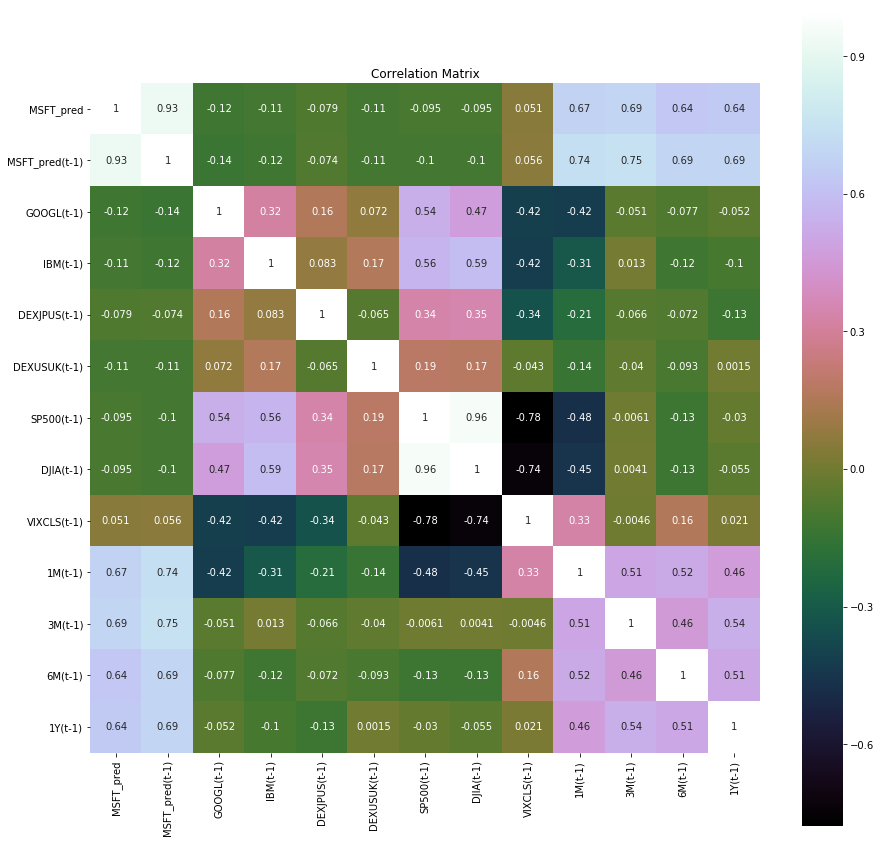

In [24]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

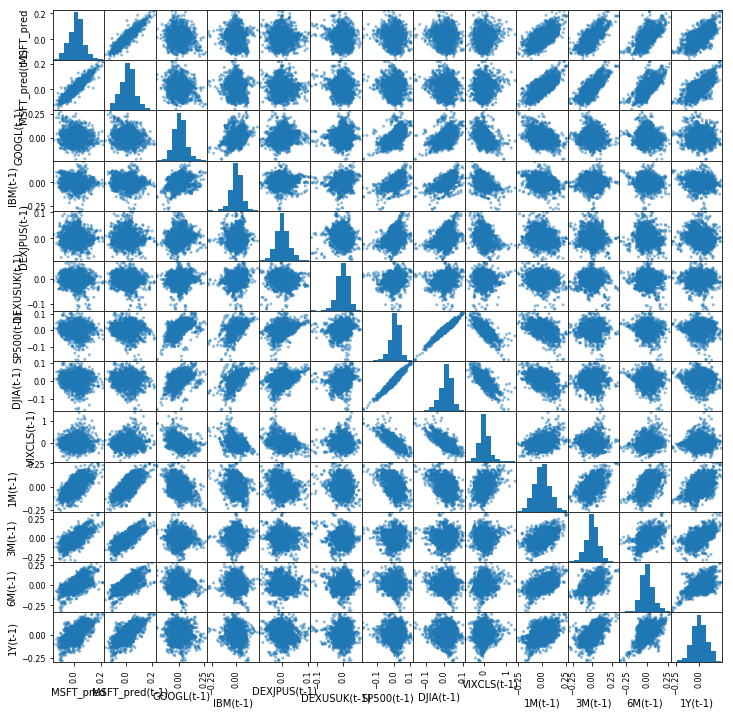

In [25]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

<a id='2.3'></a>
## 3.3. Time Series Analysis

Time series broken down into different time series comonent 

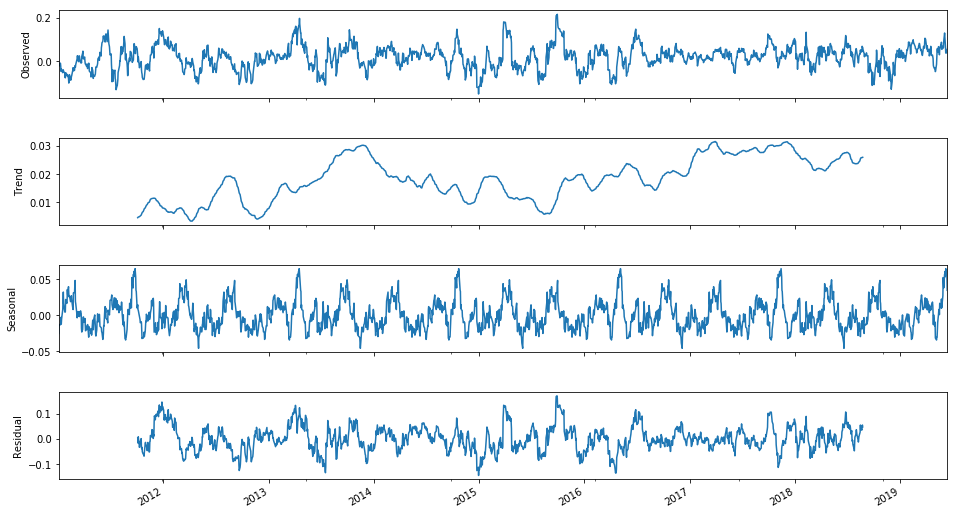

In [102]:
Y= dataset["MSFT_pred"]
res = sm.tsa.seasonal_decompose(Y,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Checking whether time series has autocorrelation

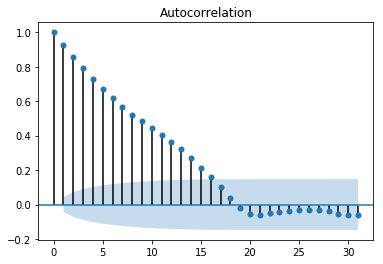

In [105]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Y, lags=31)
pyplot.show()

Significant autocorrelation, so the time series models are also used.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [26]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values drop the rown contianing the null values.

In [27]:
# Drop the rows containing NA
#dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())

<a id='3.3'></a>
## 4.3. Feature Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.
The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Dataset.

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(k=5)
bestfeatures

SelectKBest(k=5, score_func=<function f_classif at 0x00000233CD08B158>)

In [29]:
type(dataset)

pandas.core.frame.DataFrame

In [30]:
Y= dataset["MSFT_pred"]
X = dataset.loc[:, dataset.columns != 'MSFT_pred']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

             Specs    Score
0   MSFT_pred(t-1)  582.512
1       GOOGL(t-1)   13.955
10         6M(t-1)    7.143
9          3M(t-1)    5.876
4     DEXUSUK(t-1)    3.155
8          1M(t-1)    1.374
7      VIXCLS(t-1)    1.162
11         1Y(t-1)    1.122
5       SP500(t-1)    1.047
6        DJIA(t-1)    0.666


As it can be seen from the result above that t-1 is an important feature

<a id='3.4'></a>
## 4.4. Data Transformation

<a id='3.4.1'></a>
### 4.4.1. Rescale Data
When your data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale. Often this is referred to
as normalization and attributes are often rescaled into the range between 0 and 1.

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
rescaledX.head(5)

0      1      2      3      4      5      6      7      8      9      10     11
0  0.407  0.557  0.597  0.371  0.566  0.754  0.706  0.361  0.423  0.258  0.405  0.703
1  0.368  0.546  0.597  0.399  0.613  0.754  0.719  0.355  0.397  0.285  0.438  0.730
2  0.389  0.550  0.594  0.459  0.542  0.769  0.730  0.347  0.405  0.296  0.447  0.720
3  0.352  0.534  0.629  0.382  0.543  0.749  0.717  0.363  0.324  0.298  0.410  0.695
4  0.381  0.532  0.606  0.395  0.586  0.730  0.711  0.369  0.386  0.319  0.502  0.708

<a id='3.4.2'></a>
### 4.4.2. Standardize Data
Standardization is a useful technique to transform attributes with a Gaussian distribution and
differing means and standard deviations to a standard Gaussian distribution with a mean of
0 and a standard deviation of 1.

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
StandardisedX.head(5)

0      1      2      3      4      5      6      7      8      9      10     11
0 -0.346  0.676  0.262 -0.644 -0.562  0.884  0.519 -0.094 -0.520 -1.680 -1.069  0.926
1 -0.610  0.585  0.257 -0.441 -0.175  0.883  0.623 -0.152 -0.689 -1.470 -0.806  1.103
2 -0.471  0.619  0.233 -0.011 -0.761  1.015  0.711 -0.233 -0.638 -1.388 -0.740  1.039
3 -0.720  0.495  0.557 -0.561 -0.753  0.844  0.612 -0.081 -1.156 -1.371 -1.028  0.871
4 -0.527  0.480  0.344 -0.469 -0.394  0.677  0.561 -0.027 -0.761 -1.204 -0.299  0.960

<a id='3.4.3'></a>
### 4.4.1. Normalize Data
Normalizing in scikit-learn refers to rescaling each observation (row) to have a length of 1 (called
a unit norm or a vector with the length of 1 in linear algebra).

In [33]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
NormalizedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
NormalizedX.head(5)

0      1      2      3      4      5      6      7      8      9      10     11
0 -0.007  0.281  0.080 -0.072 -0.076  0.192  0.127 -0.114 -0.209 -0.696 -0.398  0.388
1 -0.084  0.262  0.082 -0.048 -0.032  0.200  0.151 -0.191 -0.289 -0.636 -0.312  0.479
2 -0.044  0.277  0.076  0.012 -0.104  0.226  0.169 -0.297 -0.271 -0.608 -0.289  0.458
3 -0.111  0.224  0.162 -0.062 -0.099  0.186  0.144 -0.099 -0.469 -0.573 -0.386  0.369
4 -0.072  0.275  0.129 -0.062 -0.071  0.197  0.170 -0.041 -0.387 -0.632 -0.134  0.508

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [112]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

In [113]:
X_train

MSFT_pred(t-1)  GOOGL(t-1)   IBM(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  SP500(t-1)  \
2011-01-04      -1.430e-03   5.533e-02  1.572e-02    -1.424e-02    -1.493e-02   3.778e-02   
2011-01-05      -1.579e-02   4.957e-02  1.543e-02    -8.988e-03    -6.013e-03   3.777e-02   
2011-01-06      -8.248e-03   5.174e-02  1.411e-02     2.165e-03    -1.949e-02   4.225e-02   
2011-01-07      -2.175e-02   4.392e-02  3.171e-02    -1.207e-02    -1.931e-02   3.643e-02   
2011-01-10      -1.125e-02   4.292e-02  2.014e-02    -9.707e-03    -1.106e-02   3.075e-02   
2011-01-11      -8.898e-03   3.768e-02  2.288e-02    -1.308e-02    -1.440e-02   2.339e-02   
2011-01-12      -2.194e-02   3.940e-02  1.684e-02    -2.516e-03    -1.612e-02   2.706e-02   
2011-01-13      -4.660e-02   3.674e-02  3.286e-02    -2.758e-03    -5.014e-03   3.511e-02   
2011-01-14      -3.465e-02   3.596e-02  2.036e-02    -1.583e-02     1.633e-02   3.854e-02   
2011-01-18      -4.261e-02   5.581e-02  3.583e-02    -1.483e-02     1.664e-02   3.973e-02   
2011-01-19      -5.303e-02   7.787e-02  4.133e-02    -1.274e-02     3.039e-02   3.772e-02   
2011-01-20      -3.937e-02   6.702e-02  7.113e-02    -2.087e-02     3.364e-02   2.154e-02   
2011-01-21      -4.068e-02   5.192e-02  7.522e-02    -6.483e-03     3.103e-02   1.687e-02   
2011-01-25      -4.649e-02   1.442e-02  6.482e-02    -4.106e-03     3.803e-02   2.093e-02   
2011-01-26      -5.497e-02   2.562e-02  1.013e-01    -6.777e-03     2.795e-02   2.640e-02   
2011-01-27      -7.476e-02   2.317e-02  1.026e-01     7.296e-04     3.361e-02   2.984e-02   
2011-01-28      -7.675e-02   2.940e-02  1.002e-01     1.370e-02     2.818e-02   3.107e-02   
2011-02-01      -5.311e-02  -1.664e-05  8.306e-02     4.398e-03     2.856e-02   1.457e-02   
2011-02-02      -6.019e-02   2.833e-02  1.084e-01    -9.814e-04     4.011e-02   2.770e-02   
2011-02-03      -6.799e-02   1.258e-02  1.019e-01    -1.710e-03     3.660e-02   2.629e-02   
2011-02-04      -6.646e-02   1.325e-02  1.022e-01    -2.113e-02     4.183e-02   2.364e-02   
2011-02-07      -6.343e-02   3.131e-03  1.091e-01    -1.405e-02     3.794e-02   2.865e-02   
2011-02-08      -7.957e-02   1.287e-03  1.032e-01    -7.737e-03     3.480e-02   3.671e-02   
2011-02-09      -1.011e-01   3.142e-03  1.195e-01    -1.044e-02     3.208e-02   4.227e-02   
2011-02-10      -7.953e-02   3.721e-03  1.130e-01    -1.073e-02     2.907e-02   3.576e-02   
2011-02-11      -6.219e-02   6.978e-04  1.120e-01    -2.163e-03     2.613e-02   2.754e-02   
2011-02-14      -6.480e-02   1.229e-02  9.829e-02     9.625e-03     7.283e-03   3.475e-02   
2011-02-16      -8.799e-02   1.841e-02  9.631e-02     3.968e-03     9.343e-03   2.977e-02   
2011-02-17      -8.573e-02  -2.439e-02  8.519e-02     1.286e-02     3.930e-03   3.139e-02   
2011-02-18      -7.159e-02  -1.033e-02  5.741e-02     1.476e-02     1.126e-02   4.463e-02   
2011-02-22      -6.725e-02   5.267e-03  6.035e-02     2.406e-03     2.304e-02   4.785e-02   
2011-02-23      -4.029e-02  -2.651e-03  4.459e-02     6.047e-03     8.343e-03   1.888e-02   
2011-02-24      -2.977e-02   3.927e-04  7.391e-03     4.856e-04     2.516e-02   1.248e-02   
2011-02-25      -4.391e-02  -1.805e-02 -2.071e-04    -7.320e-03     1.375e-02   7.277e-03   
2011-02-28      -4.389e-02  -1.053e-02  1.162e-02    -1.541e-02     1.082e-02   1.553e-02   
2011-03-01      -4.187e-02  -5.511e-03  8.968e-03    -1.098e-03     2.550e-02   3.909e-02   
2011-03-02      -2.125e-02  -3.828e-04  8.714e-03    -1.343e-03     1.651e-02   1.559e-02   
2011-03-03      -2.681e-02   7.161e-04 -7.471e-03     1.717e-03     1.153e-02   6.498e-04   
2011-03-04      -2.787e-02  -2.425e-03  3.462e-03     7.185e-03     6.105e-03   2.045e-02   
2011-03-07      -1.553e-02  -1.877e-02 -5.091e-03     1.062e-02     5.616e-03   1.069e-02   
2011-03-08       2.330e-03  -3.077e-02 -1.831e-02     1.584e-03     7.122e-03  -5.647e-04   
2011-03-09       9.220e-03  -3.103e-02 -6.592e-03     3.513e-03     3.284e-03   2.098e-03   
2011-03-10   

In [96]:
X_train

MSFT_pred(t-1)  GOOGL(t-1)   IBM(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  SP500(t-1)  \
2016-08-18      -5.400e-03   6.675e-02  1.397e-02    -5.710e-02    -8.494e-03   8.486e-03   
2011-08-15       4.306e-02   6.377e-02 -3.088e-02    -2.976e-02     9.812e-03  -1.047e-01   
2018-08-23       6.509e-02  -2.936e-02  2.928e-03    -6.582e-03    -1.728e-02   1.458e-02   
2011-01-25      -4.649e-02   1.442e-02  6.482e-02    -4.106e-03     3.803e-02   2.093e-02   
2012-08-17       1.387e-02   1.472e-01  6.900e-02     5.821e-03     6.502e-03   3.065e-02   
2017-03-13       9.198e-03   3.729e-02  9.379e-03     1.560e-02    -2.902e-02   2.766e-02   
2017-10-24       6.519e-02   4.385e-02  9.473e-02     1.462e-02    -2.469e-02   2.477e-02   
2017-12-26       7.131e-02   1.938e-02 -2.966e-03     1.600e-02     6.076e-03   3.313e-02   
2016-01-15      -3.162e-02  -4.171e-02 -2.247e-02    -3.210e-02    -4.106e-02  -7.575e-02   
2014-01-07      -8.618e-03   5.438e-02  5.674e-02     1.447e-02     5.193e-03   1.194e-02   
2015-08-19      -6.602e-02  -5.950e-03 -9.638e-02     1.207e-03     4.545e-03  -1.484e-02   
2018-08-28       3.919e-02   2.694e-03  2.130e-02     1.351e-03    -1.746e-02   2.727e-02   
2013-06-21      -4.520e-02  -2.482e-02 -5.568e-02    -5.296e-02     2.826e-02  -4.142e-02   
2014-07-03       2.265e-02   6.336e-02  2.157e-02    -6.465e-03     2.430e-02   2.584e-02   
2017-12-13       4.590e-02   4.415e-03  4.957e-02     0.000e+00     1.680e-02   3.021e-02   
2017-06-13       1.944e-02   6.174e-03  2.963e-02    -3.211e-02    -1.739e-02   1.597e-02   
2015-06-02      -6.744e-02   8.015e-04  8.712e-03     3.619e-02     3.298e-03   1.630e-03   
2014-01-08      -6.337e-03   7.427e-02  7.456e-02     1.271e-02     1.097e-03   1.619e-02   
2013-07-09      -8.350e-02   4.572e-02 -4.424e-02     3.904e-02    -4.107e-02  -1.778e-03   
2014-07-09       2.272e-02   2.162e-02  4.550e-03    -9.704e-03     1.940e-02   6.355e-03   
2013-11-21      -7.580e-03   1.509e-02  6.212e-02     1.857e-02    -4.387e-03   1.510e-02   
2016-06-24       8.879e-02  -2.509e-02  4.638e-02    -3.998e-02     7.188e-03   1.084e-02   
2014-12-04      -3.708e-02  -4.870e-02  7.794e-03     5.472e-02    -1.837e-02   3.046e-02   
2011-02-11      -6.219e-02   6.978e-04  1.120e-01    -2.163e-03     2.613e-02   2.754e-02   
2014-02-03       2.242e-02   5.237e-02 -5.981e-02    -2.472e-02     5.473e-04  -2.733e-02   
2017-02-16       5.255e-03   1.185e-02  8.681e-02     1.065e-02     6.196e-03   3.525e-02   
2013-06-24      -4.456e-02  -9.591e-03 -5.731e-02    -4.199e-02     1.659e-02  -3.582e-02   
2015-12-11      -4.997e-02   1.025e-02  9.562e-03    -1.110e-02     3.831e-03  -1.652e-02   
2011-06-27       1.446e-01  -9.013e-02 -1.610e-02    -1.385e-02    -2.233e-02  -4.414e-02   
2011-02-10      -7.953e-02   3.721e-03  1.130e-01    -1.073e-02     2.907e-02   3.576e-02   
2012-07-20       1.407e-02   1.963e-02 -1.821e-02    -1.189e-02    -1.970e-03   1.524e-02   
2013-06-11      -2.195e-02   2.128e-02  8.720e-03    -2.851e-02     1.437e-02   5.561e-03   
2011-05-31       4.114e-02  -3.224e-02 -1.493e-02    -1.010e-02    -8.572e-03  -2.183e-02   
2019-01-29       6.956e-02   3.009e-02  1.868e-01    -1.039e-02     3.551e-02   6.167e-02   
2017-06-02      -1.683e-02   5.320e-02 -3.153e-02    -9.840e-03    -1.705e-03   1.741e-02   
2017-02-01       3.123e-03   2.366e-02  5.622e-02    -2.532e-02     1.136e-02   1.862e-02   
2011-06-03       7.169e-02  -1.098e-02 -3.555e-02     3.588e-03    -1.212e-02  -2.585e-02   
2019-03-29       1.042e-01   4.304e-02  5.375e-03    -3.432e-03    -1.742e-02   8.224e-03   
2017-04-12       4.450e-02  -2.898e-02 -3.389e-02    -4.342e-02     2.023e-02  -8.330e-03   
2018-03-09      -3.953e-02   4.061e-02  1.538e-02    -3.200e-02    -4.115e-03   2.115e-02   
2012-07-02      -3.730e-02  -1.361e-03  1.380e-02     1.923e-02     1.808e-02   3.879e-02   
2017-02-10       1.614e-02   4.891e-03  7.612e-02    -2.632e-02     3.232e-02   1.420e-02   
2015-02-11   

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [114]:
# test options for regression
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
#scoring = 'r2'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1. Common Models

In [115]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
models.append(('MLP', MLPRegressor()))

<a id='4.3.2'></a>
### 5.3.2. Ensemble Models

In [116]:
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

<a id='4.3.3'></a>
### 5.3.3. Deep Learning Model-NN Regressor

In [117]:
#Running deep learning models and performing cross validation takes time
#Set the following Flag to 0 if the Deep LEarning Models Flag has to be disabled
EnableDeepLearningModelsFlag = 0

def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        #The number of hidden layers can be increased
        model.add(Dense(2, activation=activation))
        # Final output layer
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model   

In [118]:
#Add Deep Learning Regressor
if ( EnableDeepLearningModelsFlag == 1):
    models.append(('DNN', KerasRegressor(build_fn=create_model, epochs=100, batch_size=20, verbose=1)))       


### K-folds cross validation

In [119]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.000410 (0.000152)
LASSO: 0.003167 (0.001412)
EN: 0.003167 (0.001412)
KNN: 0.000943 (0.000333)
CART: 0.000939 (0.000269)
SVR: 0.001293 (0.000566)
MLP: 0.000616 (0.000223)
ABR: 0.000600 (0.000154)
GBR: 0.000461 (0.000174)
RFR: 0.000513 (0.000169)
ETR: 0.000531 (0.000188)


### Algorithm comparison

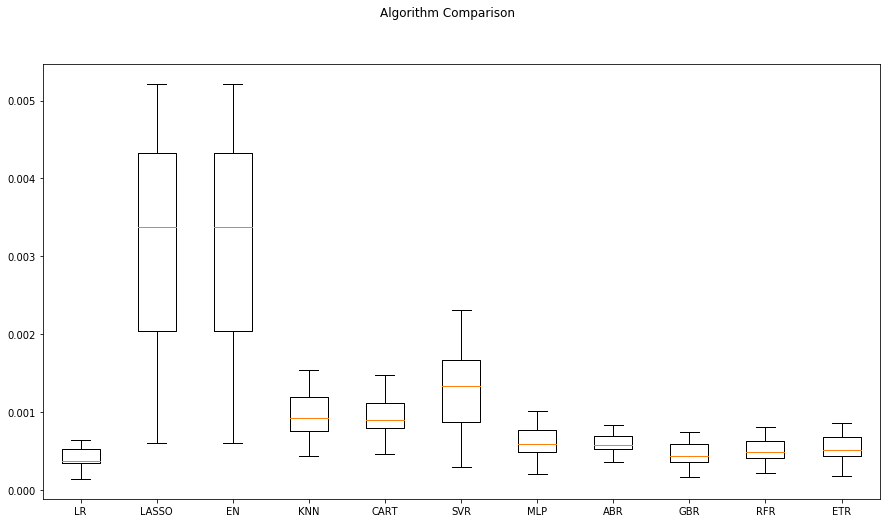

In [120]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

The chart shows MSE, the lower the better

<a id='4.4'></a>
## 5.4. Time Series based Models- ARIMA and LSTM

<a id='4.4.1'></a>
### 5.4.1 Time Series Model - ARIMA Model

In [196]:
#Preparing data for the ARIMAX Model, seperating endogeneous and exogenous variables
X_train_ARIMA=X_train.drop(['MSFT_pred(t-1)'], axis = 'columns' ).dropna()
X_validation_ARIMA=X_validation.drop(['MSFT_pred(t-1)'], axis = 'columns' ).dropna()
tr_len = len(X_train_ARIMA)
te_len = len(X_validation_ARIMA)
to_len = len (X)

2011-01-04 00:00:00 2017-09-21 00:00:00 2017-09-22 00:00:00 2019-06-12 00:00:00


In [186]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

#modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
modelARIMA= SARIMAX(Y_train,order=(1,1,0),seasonal_order=[1,0,0,0],exog = X_train_ARIMA)

model_fit = modelARIMA.fit()
#print(resultARIMA.summary())

In [200]:
error_Training = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_validation_ARIMA)[1:]
error_Test = mean_squared_error(Y_validation,predicted)
error_Test

0.0031156609965643247

<a id='4.4.2'></a>
### 5.4.2 LSTM Model

The data needs to be in 3D format for the LSTM model. So, Performing the data transform. 

In [145]:
X_train_LSTM = np.array(X_train)
Y_train_LSTM = np.array(Y_train)
X_validation_LSTM = np.array(X_validation)
Y_validation_LSTM = np.array(Y_validation)
X_train_LSTM= X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_validation_LSTM= X_validation_LSTM.reshape((X_validation_LSTM.shape[0], 1, X_validation_LSTM.shape[1]))
print(X_train_LSTM.shape, Y_train_LSTM.shape, X_validation_LSTM.shape, Y_validation_LSTM.shape)

(1604, 1, 12) (1604,) (401, 1, 12) (401,)


In [167]:
# design network
from matplotlib import pyplot
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
#More number of cells can be added if needed 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train_LSTM, Y_train_LSTM, epochs=50, batch_size=72, verbose=0, shuffle=False)# plot history


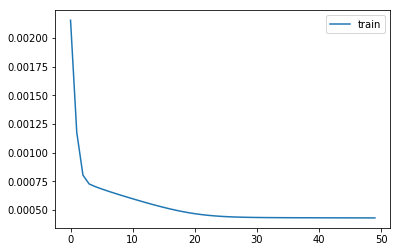

MSE from LSTM Model 0.00043005472182080227


In [166]:
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
print("MSE from LSTM Model", history.history['loss'][-1])

In [ ]:
# 1. Grid search : LSTM Model
'''
n_input: The number of prior inputs to use as input for the model (e.g. 12 months).
n_nodes: The number of nodes to use in the hidden layer (e.g. 50).
n_epochs: The number of training epochs (e.g. 1000).
n_batch: The number of samples to include in each mini-batch (e.g. 32).
n_diff: The difference order (e.g. 0 or 12).
'''
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [168]:
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [100]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

<a id='5'></a>
# 6. Model Tuning and Grid Search

Algorithm Tuning: Although some of the models show the most promising options. the grid search for Gradient Bossting Classifier is shown below.

In [61]:
# 1. Grid search : LinearRegression
'''
fit_intercept : boolean, optional, default True
    whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (e.g. data is expected to be already centered).
'''
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000493 using {'fit_intercept': True}
-0.000493 (0.000053) with: {'fit_intercept': True}
-0.000672 (0.000079) with: {'fit_intercept': False}


In [62]:
# 2. Grid search : Lasso
'''
alpha : float, optional
    Constant that multiplies the L1 term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.
''' 
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5]}
model = Lasso()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.002973 using {'alpha': 0.01}
-0.002973 (0.000203) with: {'alpha': 0.01}
-0.002973 (0.000203) with: {'alpha': 0.1}
-0.002973 (0.000203) with: {'alpha': 0.3}
-0.002973 (0.000203) with: {'alpha': 0.7}
-0.002973 (0.000203) with: {'alpha': 1}
-0.002973 (0.000203) with: {'alpha': 1.5}
-0.002973 (0.000203) with: {'alpha': 3}
-0.002973 (0.000203) with: {'alpha': 5}


In [64]:
# 3. Grid Search : ElasticNet
'''
alpha : float, optional
    Constant that multiplies the penalty terms. Defaults to 1.0.
    See the notes for the exact mathematical meaning of this
    parameter.``alpha = 0`` is equivalent to an ordinary least square,
    solved by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.

l1_ratio : float
    The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For
    ``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` it
    is an L1 penalty.  For ``0 < l1_ratio < 1``, the penalty is a
    combination of L1 and L2.
'''
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5],
              'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]}
model = ElasticNet()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000942 using {'alpha': 0.01, 'l1_ratio': 0.01}
-0.000942 (0.000109) with: {'alpha': 0.01, 'l1_ratio': 0.01}
-0.001342 (0.000126) with: {'alpha': 0.01, 'l1_ratio': 0.1}
-0.002812 (0.000210) with: {'alpha': 0.01, 'l1_ratio': 0.3}
-0.002973 (0.000203) with: {'alpha': 0.01, 'l1_ratio': 0.5}
-0.002973 (0.000203) with: {'alpha': 0.01, 'l1_ratio': 0.7}
-0.002973 (0.000203) with: {'alpha': 0.01, 'l1_ratio': 0.9}
-0.002973 (0.000203) with: {'alpha': 0.01, 'l1_ratio': 0.99}
-0.002551 (0.000180) with: {'alpha': 0.1, 'l1_ratio': 0.01}
-0.002973 (0.000203) with: {'alpha': 0.1, 'l1_ratio': 0.1}
-0.002973 (0.000203) with: {'alpha': 0.1, 'l1_ratio': 0.3}
-0.002973 (0.000203) with: {'alpha': 0.1, 'l1_ratio': 0.5}
-0.002973 (0.000203) with: {'alpha': 0.1, 'l1_ratio': 0.7}
-0.002973 (0.000203) with: {'alpha': 0.1, 'l1_ratio': 0.9}
-0.002973 (0.000203) with: {'alpha': 0.1, 'l1_ratio': 0.99}
-0.002964 (0.000203) with: {'alpha': 0.3, 'l1_ratio': 0.01}
-0.002973 (0.000203) with: {'alpha': 0.3, 'l1_r

In [65]:

# 4. Grid search : KNeighborsRegressor 
'''
n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for :meth:`kneighbors` queries.
'''
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21]}
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -0.000353 using {'n_neighbors': 3}
-0.000450 (0.000073) with: {'n_neighbors': 1}
-0.000353 (0.000063) with: {'n_neighbors': 3}
-0.000368 (0.000063) with: {'n_neighbors': 5}
-0.000395 (0.000065) with: {'n_neighbors': 7}
-0.000410 (0.000062) with: {'n_neighbors': 9}
-0.000431 (0.000067) with: {'n_neighbors': 11}
-0.000450 (0.000062) with: {'n_neighbors': 13}
-0.000466 (0.000070) with: {'n_neighbors': 15}
-0.000483 (0.000073) with: {'n_neighbors': 17}
-0.000496 (0.000075) with: {'n_neighbors': 19}
-0.000513 (0.000077) with: {'n_neighbors': 21}


In [66]:
# 5. Grid search : DecisionTreeRegressor 
'''
min_samples_split : int, float, optional (default=2)
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a percentage and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.
'''
param_grid={'min_samples_split': [2,3,4,5,6,7,8,9,10]}
model = DecisionTreeRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000661 using {'min_samples_split': 10}
-0.000718 (0.000086) with: {'min_samples_split': 2}
-0.000701 (0.000084) with: {'min_samples_split': 3}
-0.000698 (0.000085) with: {'min_samples_split': 4}
-0.000687 (0.000090) with: {'min_samples_split': 5}
-0.000683 (0.000074) with: {'min_samples_split': 6}
-0.000690 (0.000087) with: {'min_samples_split': 7}
-0.000689 (0.000084) with: {'min_samples_split': 8}
-0.000675 (0.000076) with: {'min_samples_split': 9}
-0.000661 (0.000067) with: {'min_samples_split': 10}


In [68]:
# 6. Grid search : SVR 
'''
C : float, optional (default=1.0)
    Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)
     Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
     within which no penalty is associated in the training loss function
     with points predicted within a distance epsilon from the actual
     value.
gamma : float, optional (default='auto')
    Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    If gamma is 'auto' then 1/n_features will be used instead.
'''
param_grid={'C': [0.01, 0.03,0.1,0.3,1,3,10,30,100],
            'gamma': [0.001, 0.01, 0.1, 1]},
            #'epslion': [0.01, 0.1, 1]}
model = SVR()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001026 using {'C': 30, 'gamma': 0.01}
-0.002966 (0.000202) with: {'C': 0.01, 'gamma': 0.001}
-0.002907 (0.000199) with: {'C': 0.01, 'gamma': 0.01}
-0.002519 (0.000178) with: {'C': 0.01, 'gamma': 0.1}
-0.001770 (0.000129) with: {'C': 0.01, 'gamma': 1}
-0.002952 (0.000201) with: {'C': 0.03, 'gamma': 0.001}
-0.002791 (0.000192) with: {'C': 0.03, 'gamma': 0.01}
-0.002142 (0.000153) with: {'C': 0.03, 'gamma': 0.1}
-0.001467 (0.000113) with: {'C': 0.03, 'gamma': 1}
-0.002907 (0.000199) with: {'C': 0.1, 'gamma': 0.001}
-0.002511 (0.000176) with: {'C': 0.1, 'gamma': 0.01}
-0.001711 (0.000130) with: {'C': 0.1, 'gamma': 0.1}
-0.001258 (0.000112) with: {'C': 0.1, 'gamma': 1}
-0.002790 (0.000192) with: {'C': 0.3, 'gamma': 0.001}
-0.002132 (0.000155) with: {'C': 0.3, 'gamma': 0.01}
-0.001381 (0.000115) with: {'C': 0.3, 'gamma': 0.1}
-0.001056 (0.000131) with: {'C': 0.3, 'gamma': 1}
-0.002510 (0.000175) with: {'C': 1, 'gamma': 0.001}
-0.001702 (0.000129) with: {'C': 1, 'gamma': 0.01}
-0.001

In [69]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000611 using {'hidden_layer_sizes': (50,)}
-0.001370 (0.000507) with: {'hidden_layer_sizes': (20,)}
-0.000611 (0.000142) with: {'hidden_layer_sizes': (50,)}
-0.000785 (0.000223) with: {'hidden_layer_sizes': (20, 20)}
-0.000690 (0.000161) with: {'hidden_layer_sizes': (20, 30, 20)}


In [70]:
# 8. Grid search : RandomForestRegressor 
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000317 using {'n_estimators': 400}
-0.000330 (0.000043) with: {'n_estimators': 50}
-0.000320 (0.000042) with: {'n_estimators': 100}
-0.000319 (0.000043) with: {'n_estimators': 150}
-0.000318 (0.000040) with: {'n_estimators': 200}
-0.000317 (0.000040) with: {'n_estimators': 250}
-0.000320 (0.000042) with: {'n_estimators': 300}
-0.000318 (0.000042) with: {'n_estimators': 350}
-0.000317 (0.000040) with: {'n_estimators': 400}


In [ ]:

# 9. Grid search : GradientBoostingRegressor 
'''
n_estimators:

    The number of boosting stages to perform. Gradient boosting
    is fairly robust to over-fitting so a large number usually
    results in better performance.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [72]:
# 10. Grid search : ExtraTreesRegressor 
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000256 using {'n_estimators': 200}
-0.000263 (0.000042) with: {'n_estimators': 50}
-0.000259 (0.000040) with: {'n_estimators': 100}
-0.000259 (0.000041) with: {'n_estimators': 150}
-0.000256 (0.000039) with: {'n_estimators': 200}
-0.000256 (0.000038) with: {'n_estimators': 250}
-0.000256 (0.000038) with: {'n_estimators': 300}
-0.000256 (0.000038) with: {'n_estimators': 350}
-0.000257 (0.000038) with: {'n_estimators': 400}


In [73]:
# 11. Grid search : AdaBoostRegre
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated.
    In case of perfect fit, the learning procedure is stopped early.

learning_rate : float, optional (default=1.)
    Learning rate shrinks the contribution of each regressor by
    ``learning_rate``. There is a trade-off between ``learning_rate`` and
    ``n_estimators``.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400],
             'learning_rate': [1, 2, 3]}
model = AdaBoostRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000506 using {'learning_rate': 3, 'n_estimators': 400}
-0.000568 (0.000053) with: {'learning_rate': 1, 'n_estimators': 50}
-0.000539 (0.000059) with: {'learning_rate': 1, 'n_estimators': 100}
-0.000536 (0.000054) with: {'learning_rate': 1, 'n_estimators': 150}
-0.000536 (0.000055) with: {'learning_rate': 1, 'n_estimators': 200}
-0.000531 (0.000055) with: {'learning_rate': 1, 'n_estimators': 250}
-0.000529 (0.000053) with: {'learning_rate': 1, 'n_estimators': 300}
-0.000525 (0.000053) with: {'learning_rate': 1, 'n_estimators': 350}
-0.000525 (0.000053) with: {'learning_rate': 1, 'n_estimators': 400}
-0.000532 (0.000045) with: {'learning_rate': 2, 'n_estimators': 50}
-0.000513 (0.000048) with: {'learning_rate': 2, 'n_estimators': 100}
-0.000513 (0.000048) with: {'learning_rate': 2, 'n_estimators': 150}
-0.000514 (0.000053) with: {'learning_rate': 2, 'n_estimators': 200}
-0.000515 (0.000056) with: {'learning_rate': 2, 'n_estimators': 250}
-0.000513 (0.000053) with: {'learning_rat

In [74]:
# 12. Grid search : KerasNNRegressor 
'''
nn_shape : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
''' 
param_grid={'nn_shape': [(20,), (50,), (20,20), (20, 30, 20)]}
model = KerasNNRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1440/1440 [==============================] - 1s 464us/step - loss: 0.0011
Epoch 2/100
1440/1440 [==============================] - 0s 123us/step - loss: 5.3009e-04
Epoch 3/100
1440/1440 [==============================] - 0s 127us/step - loss: 5.0230e-04
Epoch 4/100
1440/1440 [==============================] - 0s 126us/step - loss: 4.9547e-04
Epoch 5/100
1440/1440 [==============================] - 0s 130us/step - loss: 4.9252e-04
Epoch 6/100
1440/1440 [==============================] - 0s 130us/step - loss: 4.9619e-04
Epoch 7/100
1440/1440 [==============================] - 0s 126us/step - loss: 4.8936e-04
Epoch 8/100
1440/1440 [==============================] - 0s 136us/step - loss: 4.7125e-04
Epoch 9/100
1440/1440 [==============================] - 0s 130us/step - loss: 4.7051e-04
Epoch 10/100
1440/1440 [==============================] - 0s 128us/step - 

1440/1440 [==============================] - 0s 142us/step - loss: 3.4058e-04
Epoch 75/100
1440/1440 [==============================] - 0s 130us/step - loss: 3.4526e-04
Epoch 76/100
1440/1440 [==============================] - 0s 134us/step - loss: 3.4838e-04
Epoch 77/100
1440/1440 [==============================] - 0s 139us/step - loss: 3.3981e-04
Epoch 78/100
1440/1440 [==============================] - 0s 133us/step - loss: 3.4041e-04
Epoch 79/100
1440/1440 [==============================] - 0s 129us/step - loss: 3.3899e-04
Epoch 80/100
1440/1440 [==============================] - 0s 132us/step - loss: 3.3790e-04
Epoch 81/100
1440/1440 [==============================] - 0s 130us/step - loss: 3.4465e-04
Epoch 82/100
1440/1440 [==============================] - 0s 145us/step - loss: 3.3558e-04
Epoch 83/100
1440/1440 [==============================] - 0s 139us/step - loss: 3.3718e-04
Epoch 84/100
1440/1440 [==============================] - 0s 133us/step - loss: 3.3172e-04
Epoch 85/100

1440/1440 [==============================] - 0s 133us/step - loss: 3.3489e-04
Epoch 53/100
1440/1440 [==============================] - 0s 130us/step - loss: 3.3649e-04
Epoch 54/100
1440/1440 [==============================] - 0s 133us/step - loss: 3.3651e-04
Epoch 55/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.3209e-04
Epoch 56/100
1440/1440 [==============================] - 0s 132us/step - loss: 3.2684e-04
Epoch 57/100
1440/1440 [==============================] - 0s 142us/step - loss: 3.3664e-04
Epoch 58/100
1440/1440 [==============================] - 0s 148us/step - loss: 3.2953e-04
Epoch 59/100
1440/1440 [==============================] - 0s 132us/step - loss: 3.3680e-04
Epoch 60/100
1440/1440 [==============================] - 0s 134us/step - loss: 3.2349e-04
Epoch 61/100
1440/1440 [==============================] - 0s 132us/step - loss: 3.3350e-04
Epoch 62/100
1440/1440 [==============================] - 0s 132us/step - loss: 3.1998e-04
Epoch 63/100

1440/1440 [==============================] - 0s 139us/step - loss: 3.7408e-04
Epoch 31/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.7883e-04
Epoch 32/100
1440/1440 [==============================] - 0s 135us/step - loss: 3.7513e-04
Epoch 33/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.8384e-04
Epoch 34/100
1440/1440 [==============================] - 0s 137us/step - loss: 3.7551e-04
Epoch 35/100
1440/1440 [==============================] - 0s 138us/step - loss: 3.7015e-04
Epoch 36/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.8176e-04
Epoch 37/100
1440/1440 [==============================] - 0s 135us/step - loss: 3.6755e-04
Epoch 38/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.6586e-04
Epoch 39/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.7168e-04
Epoch 40/100
1440/1440 [==============================] - 0s 135us/step - loss: 3.6715e-04
Epoch 41/100

1440/1440 [==============================] - 0s 146us/step - loss: 4.2533e-04
Epoch 9/100
1440/1440 [==============================] - 0s 141us/step - loss: 4.1900e-04
Epoch 10/100
1440/1440 [==============================] - 0s 140us/step - loss: 4.2797e-04
Epoch 11/100
1440/1440 [==============================] - 0s 139us/step - loss: 4.0992e-04
Epoch 12/100
1440/1440 [==============================] - 0s 139us/step - loss: 4.0396e-04
Epoch 13/100
1440/1440 [==============================] - 0s 139us/step - loss: 4.0597e-04
Epoch 14/100
1440/1440 [==============================] - 0s 137us/step - loss: 4.0329e-04
Epoch 15/100
1440/1440 [==============================] - 0s 140us/step - loss: 3.9706e-04
Epoch 16/100
1440/1440 [==============================] - 0s 143us/step - loss: 3.9247e-04
Epoch 17/100
1440/1440 [==============================] - 0s 141us/step - loss: 3.9333e-04
Epoch 18/100
1440/1440 [==============================] - 0s 141us/step - loss: 3.8915e-04
Epoch 19/100


1440/1440 [==============================] - 0s 148us/step - loss: 3.2696e-04
Epoch 88/100
1440/1440 [==============================] - 0s 141us/step - loss: 3.2838e-04
Epoch 89/100
1440/1440 [==============================] - 0s 139us/step - loss: 3.2930e-04
Epoch 90/100
1440/1440 [==============================] - 0s 139us/step - loss: 3.2342e-04
Epoch 91/100
1440/1440 [==============================] - 0s 138us/step - loss: 3.2398e-04
Epoch 92/100
1440/1440 [==============================] - 0s 140us/step - loss: 3.2008e-04
Epoch 93/100
1440/1440 [==============================] - 0s 139us/step - loss: 3.1961e-04
Epoch 94/100
1440/1440 [==============================] - 0s 140us/step - loss: 3.3402e-04
Epoch 95/100
1440/1440 [==============================] - 0s 141us/step - loss: 3.1940e-04
Epoch 96/100
1440/1440 [==============================] - 0s 137us/step - loss: 3.2442e-04
Epoch 97/100
1440/1440 [==============================] - 0s 136us/step - loss: 3.1954e-04
Epoch 98/100

1440/1440 [==============================] - 0s 136us/step - loss: 2.5061e-04
Epoch 66/100
1440/1440 [==============================] - 0s 139us/step - loss: 2.3047e-04
Epoch 67/100
1440/1440 [==============================] - 0s 161us/step - loss: 2.3210e-04
Epoch 68/100
1440/1440 [==============================] - 0s 146us/step - loss: 2.3584e-04
Epoch 69/100
1440/1440 [==============================] - 0s 141us/step - loss: 2.3802e-04
Epoch 70/100
1440/1440 [==============================] - 0s 139us/step - loss: 2.3324e-04
Epoch 71/100
1440/1440 [==============================] - 0s 136us/step - loss: 2.3322e-04
Epoch 72/100
1440/1440 [==============================] - 0s 135us/step - loss: 2.2901e-04
Epoch 73/100
1440/1440 [==============================] - 0s 134us/step - loss: 2.3096e-04
Epoch 74/100
1440/1440 [==============================] - 0s 136us/step - loss: 2.2496e-04
Epoch 75/100
1440/1440 [==============================] - 0s 136us/step - loss: 2.2342e-04
Epoch 76/100

1440/1440 [==============================] - 0s 143us/step - loss: 2.8728e-04
Epoch 44/100
1440/1440 [==============================] - 0s 141us/step - loss: 2.7958e-04
Epoch 45/100
1440/1440 [==============================] - 0s 137us/step - loss: 2.7809e-04
Epoch 46/100
1440/1440 [==============================] - 0s 141us/step - loss: 2.7373e-04
Epoch 47/100
1440/1440 [==============================] - 0s 141us/step - loss: 2.7422e-04
Epoch 48/100
1440/1440 [==============================] - 0s 139us/step - loss: 2.7157e-04
Epoch 49/100
1440/1440 [==============================] - 0s 139us/step - loss: 2.6018e-04
Epoch 50/100
1440/1440 [==============================] - 0s 142us/step - loss: 2.6557e-04
Epoch 51/100
1440/1440 [==============================] - 0s 138us/step - loss: 2.6173e-04
Epoch 52/100
1440/1440 [==============================] - 0s 138us/step - loss: 2.6209e-04
Epoch 53/100
1440/1440 [==============================] - 0s 137us/step - loss: 2.6398e-04
Epoch 54/100

1440/1440 [==============================] - 0s 140us/step - loss: 3.5569e-04
Epoch 22/100
1440/1440 [==============================] - 0s 143us/step - loss: 3.4127e-04
Epoch 23/100
1440/1440 [==============================] - 0s 144us/step - loss: 3.3683e-04
Epoch 24/100
1440/1440 [==============================] - 0s 140us/step - loss: 3.4370e-04
Epoch 25/100
1440/1440 [==============================] - 0s 141us/step - loss: 3.3059e-04
Epoch 26/100
1440/1440 [==============================] - 0s 144us/step - loss: 3.4160e-04
Epoch 27/100
1440/1440 [==============================] - 0s 148us/step - loss: 3.2023e-04
Epoch 28/100
1440/1440 [==============================] - 0s 140us/step - loss: 3.2990e-04
Epoch 29/100
1440/1440 [==============================] - 0s 141us/step - loss: 3.2148e-04
Epoch 30/100
1440/1440 [==============================] - 0s 144us/step - loss: 3.1362e-04
Epoch 31/100
1440/1440 [==============================] - 0s 143us/step - loss: 3.1296e-04
Epoch 32/100

1440/1440 [==============================] - 0s 158us/step - loss: 2.2741e-04
Epoch 100/100
160/160 [==============================] - 0s 1ms/step
Epoch 1/100
1440/1440 [==============================] - 1s 488us/step - loss: 8.7622e-04
Epoch 2/100
1440/1440 [==============================] - 0s 145us/step - loss: 4.8824e-04
Epoch 3/100
1440/1440 [==============================] - 0s 142us/step - loss: 4.6576e-04
Epoch 4/100
1440/1440 [==============================] - 0s 143us/step - loss: 4.7160e-04
Epoch 5/100
1440/1440 [==============================] - 0s 175us/step - loss: 4.3731e-04
Epoch 6/100
1440/1440 [==============================] - 0s 153us/step - loss: 4.1797e-04
Epoch 7/100
1440/1440 [==============================] - 0s 170us/step - loss: 4.0211e-04
Epoch 8/100
1440/1440 [==============================] - 0s 157us/step - loss: 4.0213e-04
Epoch 9/100
1440/1440 [==============================] - 0s 148us/step - loss: 3.7728e-04
Epoch 10/100
1440/1440 [===================

1440/1440 [==============================] - 0s 168us/step - loss: 2.2990e-04
Epoch 77/100
1440/1440 [==============================] - 0s 154us/step - loss: 2.3397e-04
Epoch 78/100
1440/1440 [==============================] - 0s 168us/step - loss: 2.2882e-04
Epoch 79/100
1440/1440 [==============================] - 0s 166us/step - loss: 2.2930e-04
Epoch 80/100
1440/1440 [==============================] - 0s 158us/step - loss: 2.1504e-04
Epoch 81/100
1440/1440 [==============================] - 0s 155us/step - loss: 2.2309e-04
Epoch 82/100
1440/1440 [==============================] - 0s 155us/step - loss: 2.2086e-04
Epoch 83/100
1440/1440 [==============================] - 0s 154us/step - loss: 2.2208e-04
Epoch 84/100
1440/1440 [==============================] - 0s 159us/step - loss: 2.2598e-04
Epoch 85/100
1440/1440 [==============================] - 0s 152us/step - loss: 2.1461e-04
Epoch 86/100
1440/1440 [==============================] - 0s 157us/step - loss: 2.1819e-04
Epoch 87/100

1440/1440 [==============================] - 0s 161us/step - loss: 2.5093e-04
Epoch 55/100
1440/1440 [==============================] - 0s 154us/step - loss: 2.4756e-04
Epoch 56/100
1440/1440 [==============================] - 0s 151us/step - loss: 2.4691e-04
Epoch 57/100
1440/1440 [==============================] - 0s 163us/step - loss: 2.4663e-04
Epoch 58/100
1440/1440 [==============================] - 0s 165us/step - loss: 2.3935e-04
Epoch 59/100
1440/1440 [==============================] - 0s 169us/step - loss: 2.4187e-04
Epoch 60/100
1440/1440 [==============================] - 0s 172us/step - loss: 2.4479e-04
Epoch 61/100
1440/1440 [==============================] - 0s 167us/step - loss: 2.3652e-04
Epoch 62/100
1440/1440 [==============================] - 0s 154us/step - loss: 2.3808e-04
Epoch 63/100
1440/1440 [==============================] - 0s 168us/step - loss: 2.4553e-04
Epoch 64/100
1440/1440 [==============================] - 0s 163us/step - loss: 2.3296e-04
Epoch 65/100

1440/1440 [==============================] - 0s 176us/step - loss: 3.9617e-04
Epoch 33/100
1440/1440 [==============================] - 0s 172us/step - loss: 3.7936e-04
Epoch 34/100
1440/1440 [==============================] - 0s 172us/step - loss: 3.7577e-04
Epoch 35/100
1440/1440 [==============================] - 0s 171us/step - loss: 3.7449e-04
Epoch 36/100
1440/1440 [==============================] - 0s 169us/step - loss: 3.6843e-04
Epoch 37/100
1440/1440 [==============================] - 0s 170us/step - loss: 3.6896e-04
Epoch 38/100
1440/1440 [==============================] - 0s 185us/step - loss: 3.6348e-04
Epoch 39/100
1440/1440 [==============================] - 0s 187us/step - loss: 3.6328e-04
Epoch 40/100
1440/1440 [==============================] - 0s 175us/step - loss: 3.6701e-04
Epoch 41/100
1440/1440 [==============================] - 0s 172us/step - loss: 3.6725e-04
Epoch 42/100
1440/1440 [==============================] - 0s 184us/step - loss: 3.5817e-04
Epoch 43/100

KeyboardInterrupt: 

### Grid Search Time Series Models

In [ ]:
# 12. Grid search : ARIMA Model 
'''
arima_order
''' 

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

param_grid={'nn_shape': [(20,), (50,), (20,20), (20, 30, 20)]}
model = KerasNNRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<a id='6'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [136]:
# prepare model
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
model = RandomForestRegressor(n_estimators=250) # rbf is default kernel
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [141]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.0004657436178356194
0.845044488339073


(401,)

In [89]:
predictions

array([-4.99860225e-03, -3.08506190e-02,  6.55241737e-02, -2.97813973e-03,
       -5.38605175e-03,  4.60372724e-02, -4.90455077e-02, -4.66942772e-02,
       -5.59006425e-02,  2.51927294e-02,  4.26716856e-02,  4.83819384e-02,
        4.55434982e-02, -8.78997929e-02,  1.27476005e-02, -1.54357865e-02,
       -6.74553977e-02,  2.48525886e-03,  2.74626807e-02, -3.08493421e-02,
        8.79900353e-02,  2.30605528e-03, -5.60598067e-02, -1.07522591e-01,
       -9.65319121e-03,  4.57510716e-02,  5.78342701e-02,  2.82673006e-02,
        3.18615046e-02,  2.09046707e-02,  4.48700688e-02,  5.80614256e-02,
        3.61105600e-02,  3.15163599e-02,  4.22901710e-02,  3.82640803e-02,
        2.96031618e-02,  4.16425244e-02, -4.89188781e-02, -2.88271970e-03,
        3.82852660e-02,  1.14585492e-01,  2.76500093e-02, -3.10069721e-02,
        2.54879665e-02,  3.43781110e-03,  1.99531541e-02,  1.23799613e-01,
        3.64990954e-02,  1.05712883e-01,  4.61657162e-02, -9.79840815e-02,
        2.39656527e-02,  

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.
Let us look into the Feature Importance of the GBM model

[0.03526438 0.0124836  0.0195339  0.01320139 0.01071956 0.00956696
 0.01295224 0.4210472  0.21141951 0.11024835 0.14356291]


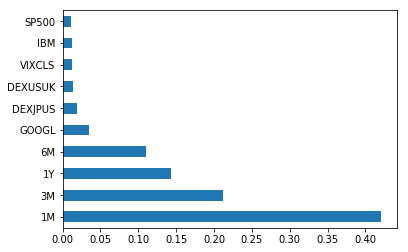

In [91]:
import pandas as pd
import numpy as np
model = RandomForestRegressor()
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

<a id='6.3'></a>
## 7.3. Save Model for Later Use

In [92]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [93]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation)
#predictions = model.predict(rescaledValidationX)
predictions = model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(result)

0.00031396254020455897
